In [1]:
import pandas as pd
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim import models
from gensim.models import CoherenceModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import os
import zipfile
import gdown

#Loading the data from the openly accessable folder on google drive
Link for data used is https://www.kaggle.com/datasets/snapcrack/all-the-news

In [ ]:
import os
import zipfile
import gdown
url = "https://drive.google.com/uc?id=1Q0kN46A-qIreOisfhyMdwGnlgcDiTU0u&export=download"

output_file = 'Archive.zip'

# Download the file using gdown with direct download link
gdown.download(url, output_file, quiet=False,fuzzy=True)
# Get the path to the current directory
current_directory = os.getcwd()

# Path to the directory where the archive.zip file is located
archive_file_path = os.path.join(current_directory, 'Archive.zip')

# Extract the CSV files from the archive.zip file to the current directory
with zipfile.ZipFile(archive_file_path, 'r') as zip_ref:
    zip_ref.extractall(current_directory)

In [4]:

# Get the path to the current directory
current_directory = os.getcwd()

csv_files = [f for f in os.listdir(current_directory) if f.endswith('.csv')]

# create an empty dataframe to store the concatenated data
df = pd.DataFrame()

# loop through each csv file and read it into a dataframe
for csv_file in csv_files:
    filepath = os.path.join(current_directory, csv_file)
    temp_df = pd.read_csv(filepath)
    
    # concatenate the dataframe with the master dataframe
    df = pd.concat([df, temp_df], ignore_index=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142570 entries, 0 to 142569
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   142570 non-null  int64  
 1   id           142570 non-null  int64  
 2   title        142568 non-null  object 
 3   publication  142570 non-null  object 
 4   author       126694 non-null  object 
 5   date         139929 non-null  object 
 6   year         139929 non-null  float64
 7   month        139929 non-null  float64
 8   url          85559 non-null   object 
 9   content      142570 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 10.9+ MB


In [6]:
# convert the "date" column to a Pandas datetime object
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [7]:
article_counts = df.groupby(df['date'].dt.year)['title'].count()

# print the article counts for each year
print(article_counts)

date
2000.0        1
2003.0        2
2004.0        2
2005.0        2
2007.0        1
2008.0        3
2009.0        3
2010.0        6
2011.0        8
2012.0       34
2013.0      228
2014.0      108
2015.0     3653
2016.0    82146
2017.0    48783
Name: title, dtype: int64


In [8]:
#Remove the skew/outliners i.e articles prior to 2012
df = df[df['date'].dt.year >= 2012]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134954 entries, 0 to 142569
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Unnamed: 0   134954 non-null  int64         
 1   id           134954 non-null  int64         
 2   title        134952 non-null  object        
 3   publication  134954 non-null  object        
 4   author       120047 non-null  object        
 5   date         134954 non-null  datetime64[ns]
 6   year         134954 non-null  float64       
 7   month        134954 non-null  float64       
 8   url          77946 non-null   object        
 9   content      134954 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 11.3+ MB


In [9]:
# get the count of number of articles per year
articles_per_year = df.groupby(df['date'].dt.year)['title'].count()

# get the count of articles per publication
articles_per_publication = df.groupby('publication')['title'].count()

# print the results
print("Articles per year:")
print(articles_per_year)

print("\nArticles per publication:")
print(articles_per_publication)

Articles per year:
date
2012       34
2013      228
2014      108
2015     3653
2016    82146
2017    48783
Name: title, dtype: int64

Articles per publication:
publication
Atlantic                7179
Breitbart              23781
Business Insider        6757
Buzzfeed News           4854
CNN                    11487
Fox News                4350
Guardian                8638
NPR                    11977
National Review         6201
New York Post          17493
New York Times          7803
Reuters                10709
Talking Points Memo     2610
Washington Post        11113
Name: title, dtype: int64


# plot the count of articles per publication as a horizontal bar plot

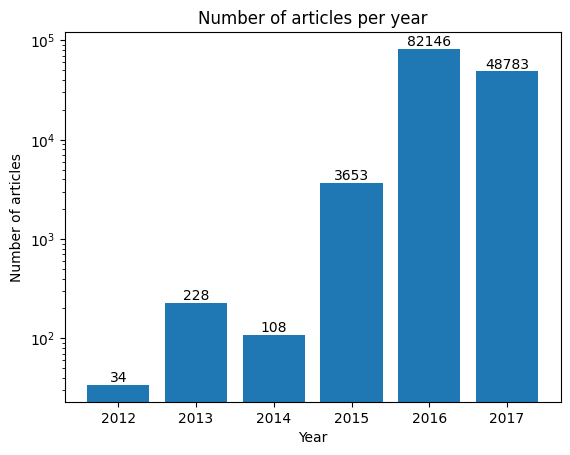

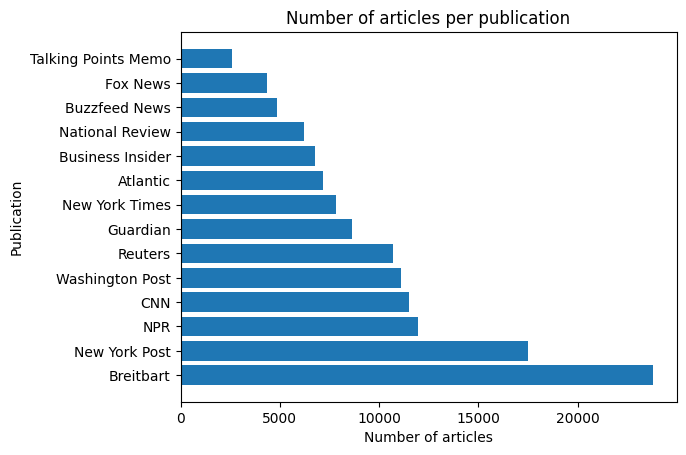

In [10]:
import matplotlib.pyplot as plt
# create a bar plot for the count of articles per year
fig, ax = plt.subplots()
bars = ax.bar(articles_per_year.index, articles_per_year.values)

# set the title and axis labels
ax.set_title('Number of articles per year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of articles')

# set a logarithmic scale for the y-axis
ax.set_yscale('log')

# add the actual numbers on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom')

# show the plot
plt.show()

# create a horizontal bar plot for the count of articles per publication
articles_per_publication = articles_per_publication.sort_values(ascending=False)
fig, ax = plt.subplots()
ax.barh(articles_per_publication.index, articles_per_publication.values)

# set the title and axis labels
ax.set_title('Number of articles per publication')
ax.set_xlabel('Number of articles')
ax.set_ylabel('Publication')

# show the plot
plt.show()

In [11]:
# combine the "title" and "content" columns for each article
df['title'] = df['title'].fillna('')
df['content'] = df['content'].fillna('')

df['text'] = df.apply(lambda row: row['title'] + ' ' + row['content'], axis=1)

#Taking the columns that are required for modelling

In [12]:
df = df.drop(["Unnamed: 0",'id','title','author','year','month','url','content'], axis=1)

In [13]:
df=df.reset_index(drop=True)

In [14]:
def perform_topic_modelling(df, num_topics):
    
    # Preprocess text data
    # Convert text to lowercase
    df['text'] = df['text'].str.lower()  
     # Tokenize text
    df['text'] = df['text'].apply(lambda x: ' '.join(word_tokenize(x))) 
    # Remove punctuation
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in string.punctuation])) 
    stop_words = stopwords.words('english')
    # Remove stop words
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))  
    lemmatizer = WordNetLemmatizer()
    # Lemmatize words
    df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))  
    df['text'] = df['text'].apply(lambda x: ' '.join(re.sub(r'[^a-zA-Z]', ' ', word) for word in x.split()))

    # Create a dictionary from the tokenized documents
    dictionary = corpora.Dictionary(df['text'].apply(lambda x: x.split()))

    # Create a bag of words corpus
    corpus = [dictionary.doc2bow(doc.split()) for doc in df['text']]

    # Create TF-IDF model
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]

    # Train the LDA model
    lda_model = gensim.models.LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=num_topics)

    # Compute coherence score
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=df['text'].apply(lambda x: x.split()), dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()

    # Visualize topics
    vis = gensimvis.prepare(lda_model, corpus_tfidf, dictionary)
    
    return coherence_score, vis

In [15]:
# Create an empty dictionary to hold the dataframes for each publication
publication_dfs = {}

# Group the data by publication
publication_groups = df.groupby('publication')

# Loop through each publication group and create a new dataframe for that publication
for publication, group_df in publication_groups:
    # Create a new dataframe for this publication
    publication_dfs[publication] = group_df.copy()

#Selecting the piblication name for topic modelling

In [16]:
print("Please choose the publication name from below if you want run on whole dataset type All")
pub = ['Atlantic', 'Breitbart', 'Business Insider', 'Buzzfeed News', 'CNN', 'Fox News', 'Guardian', 'NPR', 'National Review', 'New York Post', 'New York Times', 'Reuters', 'Talking Points Memo', 'Washington Post','All']
for i, p in enumerate(pub, 1):
    print(f"{i}. {p}")
publication_name = input("Please enter the Publication name as per the list above: ")
if publication_name=='All':
    publication_df = df.copy()
else:
    publication_df = publication_dfs[publication_name]
publication_df=publication_df.reset_index(drop=True)

Please choose the publication name from below if you want run on whole dataset type All
1. Atlantic
2. Breitbart
3. Business Insider
4. Buzzfeed News
5. CNN
6. Fox News
7. Guardian
8. NPR
9. National Review
10. New York Post
11. New York Times
12. Reuters
13. Talking Points Memo
14. Washington Post
15. All


In [17]:
publication_df

,publication,date,text
0,Reuters,2016-12-31,Trump praises Putin for holding back in U.S.-R...
1,Reuters,2016-12-30,"Russians leave country retreats in the U.S., o..."
2,Reuters,2017-01-02,"Gunman kills 39 in Istanbul nightclub, manhunt..."
3,Reuters,2017-01-01,New York’s Times Square erupts with cheer as a...
4,Reuters,2016-12-31,Investors brace for 2017 shocks after surprise...
...,...,...,...
10705,Reuters,2016-12-30,Speculators raise net long dollar bets in fina...
10706,Reuters,2016-12-31,Wall St. thinks stocks will rise in 2017 - Wha...
10707,Reuters,2016-12-30,Disney buying Netflix could be practical magic...
10708,Reuters,2017-01-03,Actors seek posthumous protections after big-s...


#Performing topic modelling and testing

In [18]:
#Performing topic modelling and testing
num_topics=int(input("Please enter no.of topics:"))
coherence_score, vis = perform_topic_modelling(publication_df, num_topics=num_topics)

In [19]:
print(f"The coherence score of topic modelling conducted of {publication_name} with {num_topics} is {coherence_score}")

The coherence score of topic modelling conducted of Reuters with 15 is 0.5230682705184233


In [20]:
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)